# Assignment overview <ignore>
The overarching goal of this assignment is to produce a research report in which you implement, analyse, and discuss various Neural Network techniques. You will be guided through the process of producing this report, which will provide you with experience in report writing that will be useful in any research project you might be involved in later in life.

All of your report, including code and Markdown/text, ***must*** be written up in ***this*** notebook. This is not typical for research, but is solely for the purpose of this assignment. Please make sure you change the title of this file so that XXXXXX is replaced by your candidate number. You can use code cells to write code to implement, train, test, and analyse your NNs, as well as to generate figures to plot data and the results of your experiments. You can use Markdown/text cells to describe and discuss the modelling choices you make, the methods you use, and the experiments you conduct. So that we can mark your reports with greater consistency, please ***do not***:

* rearrange the sequence of cells in this notebook.
* delete any cells, including the ones explaining what you need to do.

If you want to add more code cells, for example to help organise the figures you want to show, then please add them directly after the code cells that have already been provided. 

Please provide verbose comments throughout your code so that it is easy for us to interpret what you are attempting to achieve with your code. Long comments are useful at the beginning of a block of code. Short comments, e.g. to explain the purpose of a new variable, or one of several steps in some analyses, are useful on every few lines of code, if not on every line. Please do not use the code cells for writing extensive sentences/paragraphs that should instead be in the Markdown/text cells.

# Abstract/Introduction (instructions) - 15 MARKS <ignore>
Use the next Markdown/text cell to write a short introduction to your report. This should include:
* a brief description of the topic (image classification) and of the dataset being used (CIFAR10 dataset). (2 MARKS)
* a brief description of how the CIFAR10 dataset has aided the development of neural network techniques, with examples. (3 MARKS)
* a descriptive overview of what the goal of your report is, including what you investigated. (5 MARKS)
* a summary of your major findings. (3 MARKS)
* two or more relevant references. (2 MARKS)

*Enter your abstract/introduction here*

# Methodology (instructions) - 55 MARKS <ignore>
Use the next cells in this Methodology section to describe and demonstrate the details of what you did, in practice, for your research. Cite at least two academic papers that support your model choices. The overarching prinicple of writing the Methodology is to ***provide sufficient details for someone to replicate your model and to reproduce your results, without having to resort to your code***. You must include at least these components in the Methodology:
* Data - Decribe the dataset, including how it is divided into training, validation, and test sets. Describe any pre-processing you perform on the data, and explain any advantages or disadvantages to your choice of pre-processing. 
* Architecture - Describe the architecture of your model, including all relevant hyperparameters. The architecture must include 3 convolutional layers followed by two fully connected layers. Include a figure with labels to illustrate the architecture.
* Loss function - Describe the loss function(s) you are using, and explain any advantages or disadvantages there are with respect to the classification task.
* Optimiser - Describe the optimiser(s) you are using, including its hyperparameters, and explain any advantages or disadvantages there are to using that optimser.
* Experiments - Describe how you conducted each experiment, including any changes made to the baseline model that has already been described in the other Methodology sections. Explain the methods used for training the model and for assessing its performance on validation/test data.


## Data (7 MARKS) <ignore>

*Describe the dataset and any pre-processing here*

## Architecture (17 MARKS) <ignore>

*Describe the architecture here*

## Loss function (3 MARKS) <ignore>

*Describe the loss function here*

## Optimser (4 MARKS) <ignore>

*Describe the optimiser here*

## Experiments <ignore>
### Experiment 1 (8 MARKS)

*Describe how you went about conducting experiment 1 here*

### Experiment 2 (8 MARKS) <ignore>

*Describe how you went about conducting experiment 2 here*

### Experiment 3 (8 MARKS) <ignore>

*Describe how you went about conducting experiment 3 here*

In [1]:
############################################
### Code for building the baseline model ###
###    and various helper functions      ###
############################################

# Commands for setting up the environment
  # conda create -n nn_env python=3.8
  # conda activate nn_env
  # pip3 install torch==2.3.0+cu121 torchvision==0.18+cu121 matplotlib -f https://download.pytorch.org/whl/cu121/torch_stable.html
  # conda install ipykernel
  # python -m ipykernel install --user --name=nn_env --display-name="Neural Networks"
  # conda install jupyterlab
  # jupyter lab


# Imports

import torch
from   torch                  import nn
from   torch.utils.data       import DataLoader, random_split
from   torchvision            import datasets
from   torchvision.transforms import ToTensor

from   statistics             import mean
from   copy                   import deepcopy

import matplotlib.pyplot      as plt
import numpy                  as np
import time, json, pickle

###


class NeuralNetwork(nn.Module):

    """Image classifer neural network for CIFAR10 dataset."""

    def __init__(self, dropout_rate=0.0, batch_norm=False):

        """
        The dropout rate of the dropout layers is set to dropout_rate.
        If batch_norm is True, batch normalization layers will be added.
        """

        super(NeuralNetwork, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d( 3,  32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32,  64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        
        self.full_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256) if batch_norm else nn.Identity(),
            nn.ReLU(),

            nn.Dropout(dropout_rate),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.full_layers(self.flatten(self.conv_layers(x)))
        return logits


def gradient_means_stds(model):
    """Gets the means and standard deviations of gradients for each layer of the neural network"""
    stats = []
    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)): continue
        for param_name, param in module.named_parameters():
            if ('weight' not in param_name) or (param.grad is None): continue
            mean = torch.mean(param.grad)
            std  = torch.std(param.grad)
            stats.append((mean.item(), std.item()))
    return stats



def train_and_test(model, train_set, test_set, num_batches, loss_fn, optimizer, scheduler, num_epochs, device):

    """
    Splits train_set and test_set into num_batches each, uses the given loss function
    loss_fn, the optimizer, and the scheduler for training for num_epochs on given device.

    Collects data about the performance of the model after each training batch, including
    training set loss, validation set loss, accuracy, the gradient means and standard devations.
    """

    # Make sure the training and testing sets' sizes are divisible by num_batches
    assert len(train_set) % num_batches == 0
    assert len(test_set ) % num_batches == 0

    # Determine the batch size for each
    train_batch_size = len(train_set) // num_batches
    test_batch_size  = len(test_set)  // num_batches

    # Create their respective Dataloaders
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    test_loader  = DataLoader(test_set , batch_size=test_batch_size , shuffle=True)

    # Initially empty lists where performance data will be collected
    train_losses    = []
    test_losses     = []
    accuracies      = []
    gradient_stats  = []
    
    # Initial value for the smoothed testing set loss
    smoothed_test_loss = 3

    # For each epoch
    for epoch in range(num_epochs):

        # For each training and testing batch within that epoch
        for train_batch, test_batch in zip(train_loader, test_loader):

            # Evaluate the model's current performance on the testing batch
            model.eval()
            X, y = test_batch
            X, y = X.to(device), y.to(device)

            # Without updating the gradients, since this is for testing
            with torch.no_grad():
                pred = model(X)
                loss = loss_fn(pred, y)
                test_loss = loss.item()
                test_losses.append(test_loss)
                num_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                accuracies.append(num_correct / test_batch_size)

            # Train the model on the training batch
            model.train()
            X, y = train_batch
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            train_losses.append(loss.item())
            
            loss.backward()

            gradient_stats.append(gradient_means_stds(model))
            
            optimizer.step()
            optimizer.zero_grad()

            # If there is a learning rate scheduler
            if scheduler:
                
                # Update the smoothed test set loss
                smoothed_test_loss *= 0.97
                smoothed_test_loss += test_loss*0.03
                
                # Pass the scheduler the model's performance on the test set
                # so it can adjust the learning rate
                scheduler.step(smoothed_test_loss)

        # Let the user know which epoch we're on
        print(f'Epoch #{epoch+1:>3} done', end='\r', flush=True)

    # Clear the line
    print(' '*20, end='\r', flush=True)

    # Calculate the number of datapoints that will be returned
    num_datapoints = num_batches * num_epochs
    
    return train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints



def exp_smooth(nums, alpha=0.03):
    """Exponential smoothing for plots"""
    smoothed = [nums[0]]
    for i in range(1,len(nums)):
        smoothed.append(nums[i]*alpha + smoothed[-1]*(1-alpha))
    return smoothed



def plot_metrics_to_axes(metrics, ax, ticks=(), labels=False, legend=False, show_unsmoothed=False, annotate=False, max_epochs=None):

    """Plot learning curves based on metrics obtained from train_and_test()"""

    # Unpack metrics
    train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints = metrics

    # If max_epochs is set, truncate the metrics
    if max_epochs:
        num_epochs     = min(num_epochs, max_epochs)
        num_datapoints = num_epochs * num_batches
        train_losses   = train_losses[:num_datapoints]
        test_losses    = test_losses [:num_datapoints]
        accuracies     = accuracies  [:num_datapoints]

    # Calculate the generalization gap sizes
    general_gap = [a-b for (a,b) in zip(test_losses, train_losses)]

    # Calculate the smoothed versions of the metrics
    smoothed_train_losses = exp_smooth(train_losses)
    smoothed_test_losses  = exp_smooth(test_losses)
    smoothed_general_gap  = exp_smooth(general_gap)
    smoothed_accuracies   = exp_smooth(accuracies)

    # Calculate epoch numbers for the x-axis
    epochs = [v/num_batches for v in range(1, num_datapoints+1)]

    # If show_unsmoothed is set, plot the unsmoothed learning curves data
    if show_unsmoothed:
        l1, = ax.plot(epochs, train_losses, color='tab:blue'  , alpha=0.15)
        l2, = ax.plot(epochs, test_losses , color='tab:green' , alpha=0.15)
        l3, = ax.plot(epochs, general_gap , color='tab:orange', alpha=0.15)

    # Plot the smoothed learning curves data
    l4, = ax.plot(epochs, smoothed_train_losses, color='tab:blue'  , label='Training loss')
    l5, = ax.plot(epochs, smoothed_test_losses , color='tab:green' , label='Testing loss')
    l6, = ax.plot(epochs, smoothed_general_gap , color='tab:orange', label='Generalization gap')

    # Specify x and y ranges for the plot, losses range from 0 to 3
    ax.set_xlim((0,num_epochs))
    ax.set_ylim((0,3))
    ax.grid(True)

    # Create a twin x axis for accuracies having a scale from 0 to 1 and plot them
    ax2 = ax.twinx()
    l7, = ax2.plot(epochs, smoothed_accuracies  , color='tab:purple', label='Accuracy')
    ax2.set_ylim((0,1))

    # Show x and y ticks as specified in the ticks parameter
    if 'bottom' not in ticks: ax .set_xticklabels([])
    if 'left'   not in ticks: ax .set_yticklabels([])
    if 'right'  not in ticks: ax2.set_yticklabels([])

    # If labels is set, show labels
    if labels:
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy score')

    # If annotate is set, annotate the points of lowest testing loss and highest accuracy
    if annotate:
        x1,y1 = min(zip(smoothed_test_losses, epochs))[::-1]
        p1,   = ax .plot(x1, y1, 'o', markersize=10, mfc='none', mec='black', mew=2)
        x2,y2 = max(zip(smoothed_accuracies, epochs))[::-1]
        p2,   = ax2.plot(x2, y2, 'o', markersize=10, mfc='none', mec='gray' , mew=2)
        ax.legend([p1,p2],[f'({x1:>.1f},{y1:>.2f})', f'({x2:>.1f},{y2:>.2f})'])

    # If legend is set, create a legend
    if legend:
        lines  = [l4, l5, l6, l7]
        labels = [line.get_label() for line in lines]
        ax.legend(lines, labels)



def plot_metrics(metrics):
    
    """
    Plots learning curves based on information returned by train_and_test()
    for a single model
    """
    
    fig, ax = plt.subplots()
    plot_metrics_to_axes(metrics, ax, labels=True, legend=True,
                         show_unsmoothed=True, ticks=('left','bottom','right'),
                         annotate = True)
    plt.show()


# Function to plot the means and standard deviations of layer gradients
# based on output of train_and_test()

def plot_gradient_stats(metrics):

    """
    Plots the means and standard deviations of layer gradients based on
    metrics returned by train_and_test()
    """

    # Unpack metrics
    train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints = metrics

    # Get means, standard deviations, and epoch numbers for first and last 5 epochs
    gradient_stats = gradient_stats[::num_batches]
    gradient_stats = gradient_stats[:5] + gradient_stats[-5:]
    all_means, all_stds = list(zip(*[list(zip(*p)) for p in gradient_stats]))
    epoch_nums  = list(range(1,6)) + list(range(num_epochs-4,num_epochs+1))

    # Set total number of epochs and number of layers in model
    num_epochs = 10
    num_layers = 5

    # Spacing values for pretty display
    plt.figure(figsize=(20, 3))
    layer_width = 0.8
    space_between_layers = 0.2
    space_between_epochs = 2

    # Empty container for x-axis positions for the error bars
    positions = []

    # For each of the epochs
    for i in range(num_epochs):
        
        # Calculate the x positions for the error bars
        base_position = i * (num_layers * (layer_width + space_between_layers) + space_between_epochs)
        layer_positions = [base_position + j * (layer_width + space_between_layers) for j in range(num_layers)]
        positions.extend(layer_positions)

        # Plot the error bars
        plt.errorbar(layer_positions, all_means[i], yerr=all_stds[i], fmt='o', capsize=5, label=f'Epoch {epoch_nums[i]}')
    
    # Generate x-ticks positions and labels
    ticks = [np.mean(positions[i:i + num_layers]) for i in range(0, len(positions), num_layers)]
    tick_labels = [f'Epoch {epoch_nums[i]}' for i in range(num_epochs)]
    
    # Set plot details and show it
    plt.title('Gradient means and SDs for epochs')
    plt.xticks(ticks, tick_labels)
    plt.grid(True)
    plt.show()


def rec_mean(l):
    """Averages multiple lists recursively. Used to average learning curve data."""
    if all(isinstance(x,int) or isinstance(x,float) for x in l): return mean(l)
    else: return [rec_mean(x) for x in zip(*l)]


# Check available device for training
if   torch.cuda.is_available():         device='cuda'
elif torch.backends.mps.is_available(): device='mps'
else:                                   device='cpu'

# Print the device used for training
print(f'Device: {device}')

# Set resolution for plots
plt.rcParams['figure.dpi'] = 90

Device: cuda


Files already downloaded and verified
Files already downloaded and verified


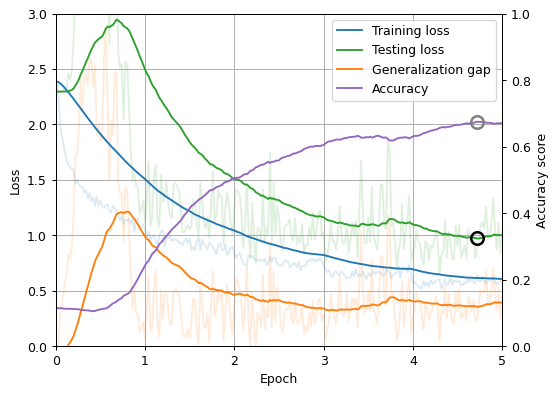

In [123]:
# Example usage

train_set = datasets.CIFAR10(root='data', train=True , download=True, transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

model     = NeuralNetwork(dropout_rate=0.1, batch_norm=True).to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = None

metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 5, device)

plot_metrics(metrics)

# Results (instructions) - 55 MARKS <ignore>
Use the Results section to summarise your findings from the experiments. For each experiment, use the Markdown/text cell to describe and explain your results, and use the code cell (and additional code cells if necessary) to conduct the experiment and produce figures to show your results.

### Experiment 1 (17 MARKS) <ignore>

*Write up results for Experiment 1 here*

In [3]:
#############################
### Code for Experiment 1 ###
#############################

In [139]:
# Get training and testing data
train_set = datasets.CIFAR10(root='data', train=True , transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, transform=ToTensor())

# Choose learning rates
learning_rates = [0.1**p for p in [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]]

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

for learning_rate in learning_rates:

    # Get the number of previous runs with this learning rate
    num_previous_runs = len(results['learning_rate'].get(learning_rate,[]))
    
    # If data for 5 runs of this learning rate already exist, no further data is needed
    if num_previous_runs >= 5: continue

    # Otherwise, create and train models with that learning rate and note their performances
    print(f'Training and testing models with learning rate = {learning_rate}')
    for i in range(num_previous_runs + 1, 6):
        print(f'Run #{i}')
        model     = NeuralNetwork().to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results['learning_rate'][learning_rate] = results['learning_rate'].get(learning_rate,[]) + [metrics]

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

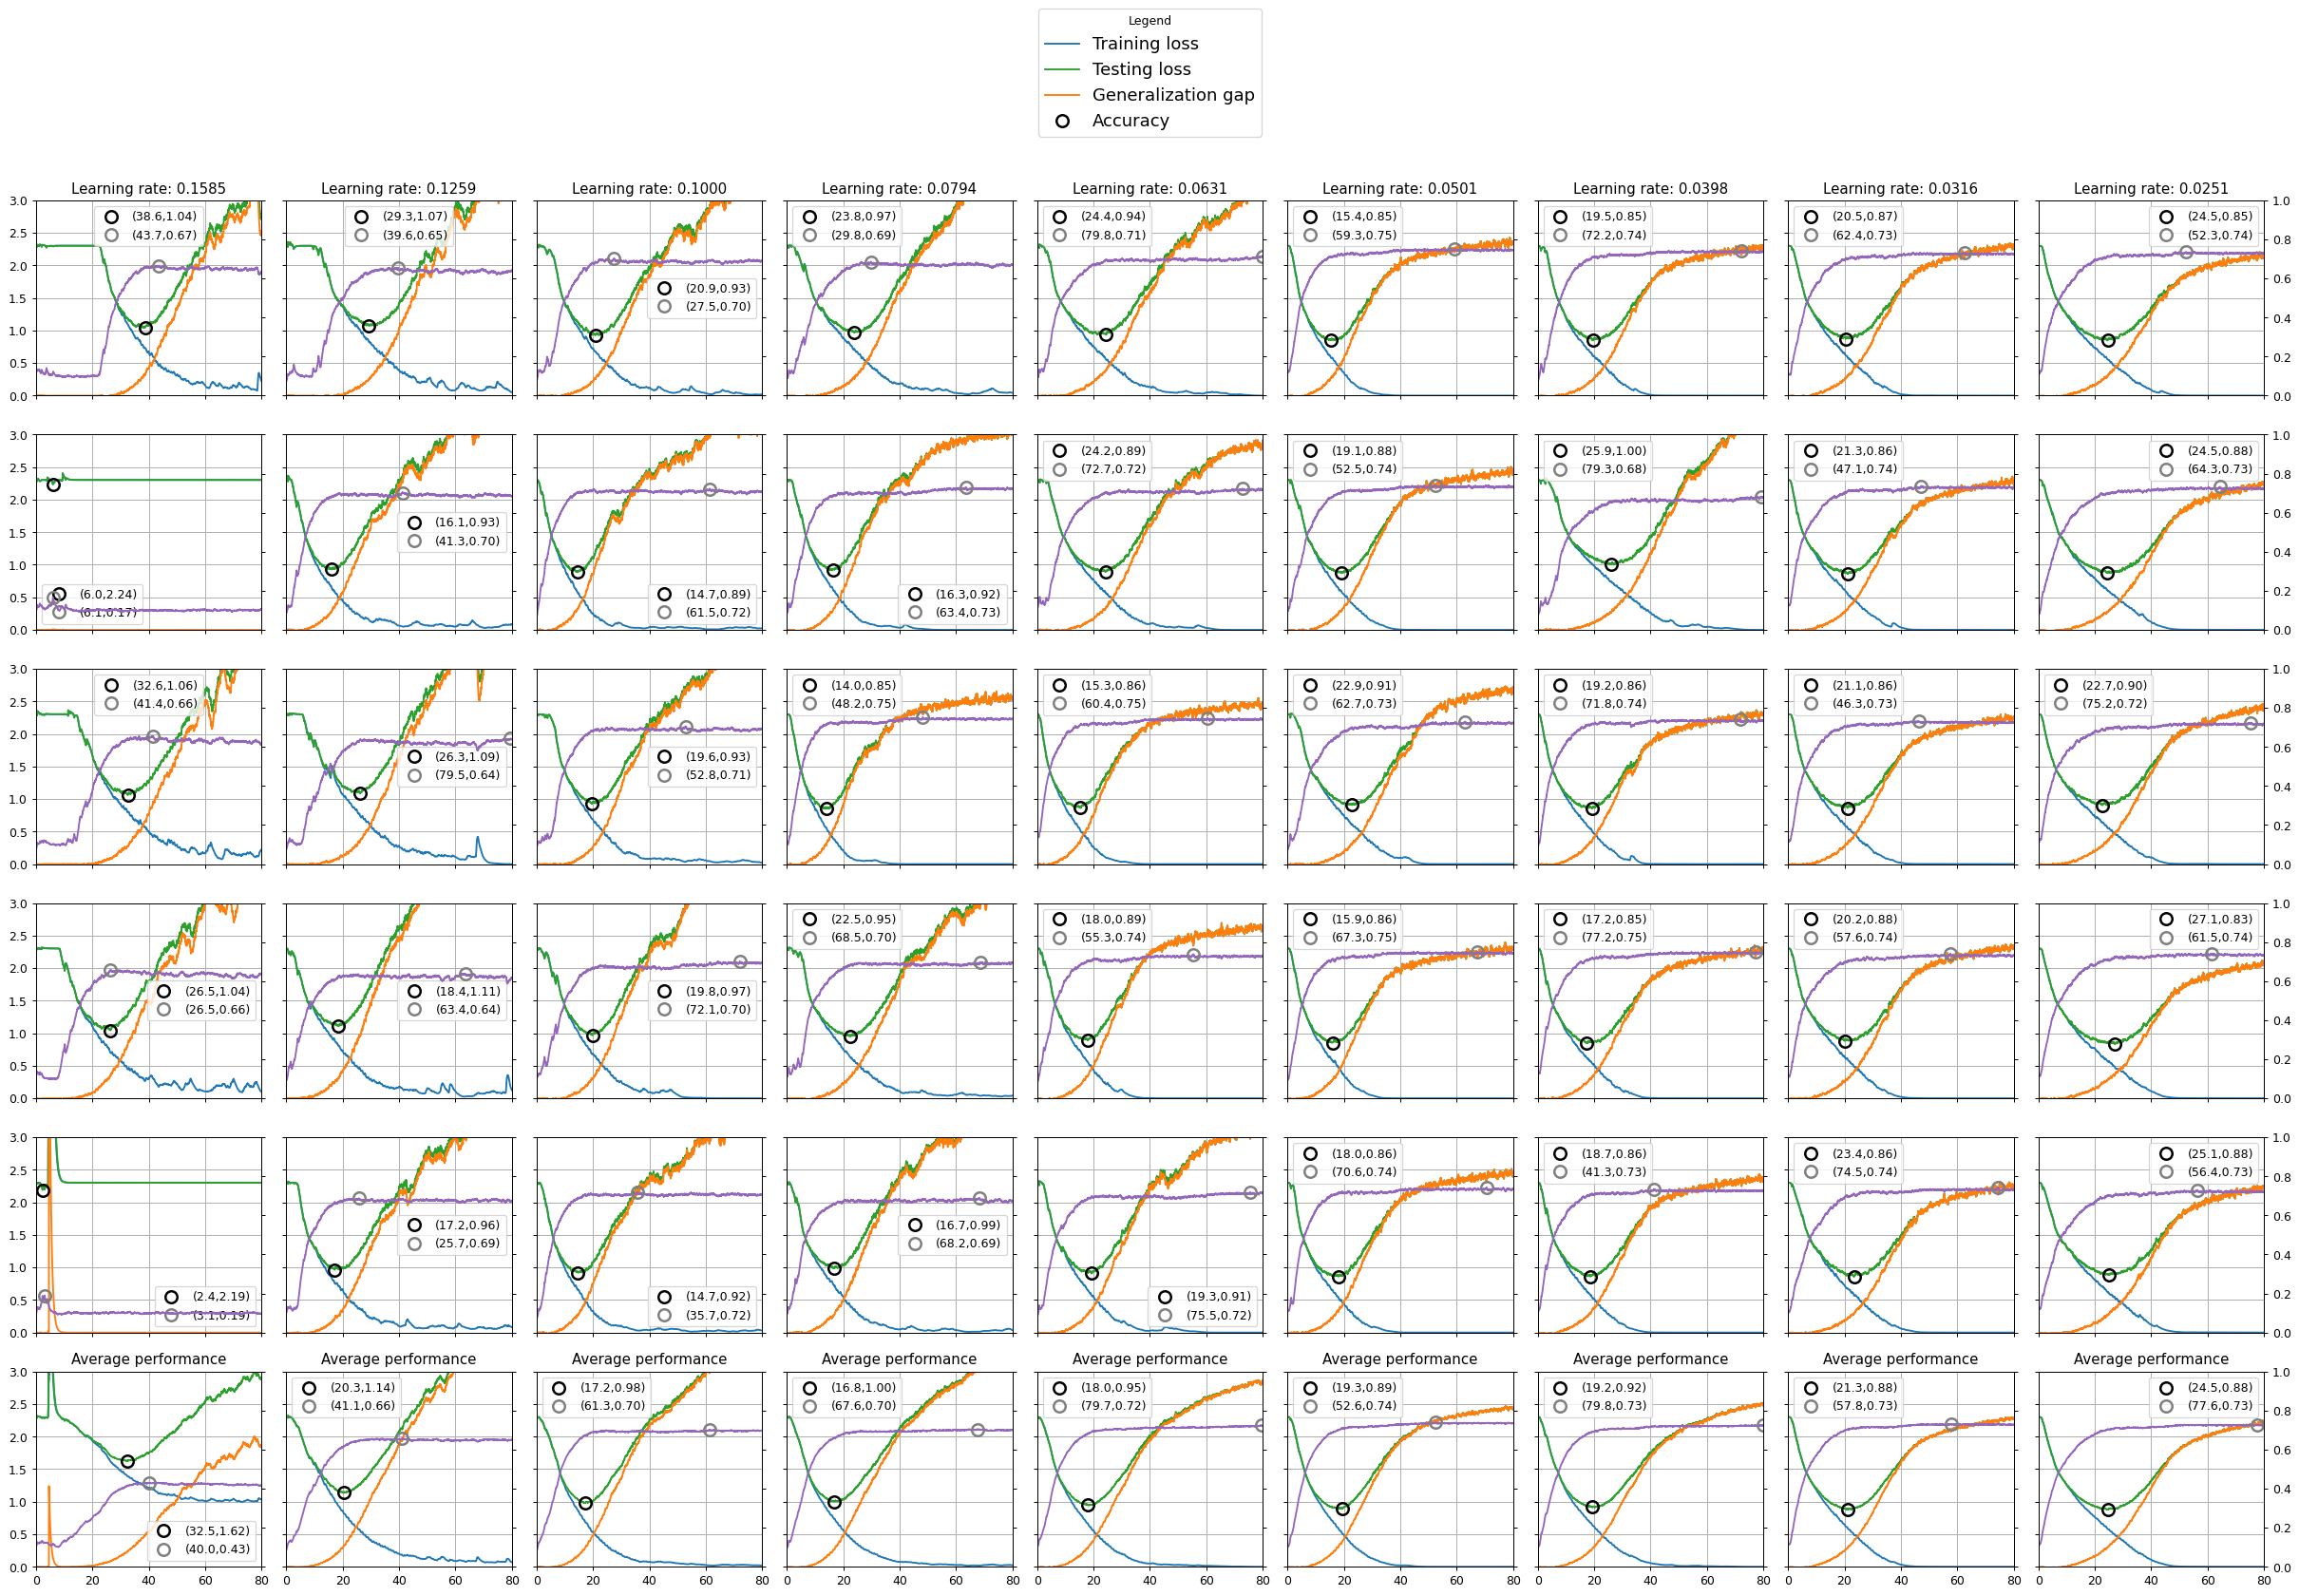

In [136]:
# Plotting results

# Create a 6x9 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=9, figsize=(27,18))

# Iterate over columns and their corresponding learning rates
for col, lr in enumerate(results['learning_rate']):
    
    # Calculate the average performance for that learning rate
    performance_mean = rec_mean(results['learning_rate'][lr])

    # Iterate over the rows in that column and the performance data that
    # corresponds to this run, as well as the average performnce
    for row, data in enumerate(results['learning_rate'][lr][:5]+[performance_mean]):

        # Draw ticks only at the edges
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==8)

        # Draw the subplot for the performance data of this run
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)

        # Only create headings for the top of the column and for the row with the average performance
        if row == 0: axes[row,col].set_title(f'Learning rate: {lr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1.04), fontsize='x-large')

# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [130]:
# Design a learning rate scheduler

# Run that 5 times as well, save metrics

# Plot the learning curves for this model, including the average

In [141]:
# Pick a learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Get the number of previous runs with this scheduler
num_previous_runs = len(results['reduce_lr_on_plateau'])

for i in range(num_previous_runs+1, 6):
    print(f'Run #{i}')
    model     = NeuralNetwork().to(device)
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1**0.1, patience=10)
    metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 30, device)
    results['reduce_lr_on_plateau'].append(metrics)

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

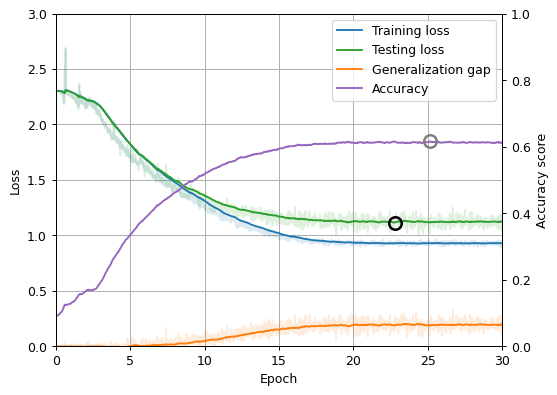

In [150]:
# Plotting the learning curves for the model trained with a scheduler
plot_metrics(rec_mean(results['reduce_lr_on_plateau']))

### Experiment 2 (19 MARKS) <ignore>

*Write up results for Experiment 2 here*

In [2]:
#############################
### Code for Experiment 2 ###
#############################

In [12]:
# Split data into two halves, one for training and one for validation
torch.manual_seed(0)
train_set = datasets.CIFAR10(root='data', train=True, transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, transform=ToTensor())
train_set, test_set  = random_split(train_set + test_set, [30000, 30000])

# Choose 5 dropout rates
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Create a container for best performing model at each dropout rate
best_performers = {dr:(-1,None) for dr in dropout_rates}

for dropout_rate in dropout_rates:

    # Get the number of previous runs with this dropout rate
    num_previous_runs = len(results['dropout_rate'].get(dropout_rate,[]))
    
    # If data for 5 runs of this dropout rate already exist, no further data is needed
    if num_previous_runs >= 5: continue
    
    # Otherwise, create and train models with that learning rate and note their performances
    print(f'Training and testing models with dropout rate = {dropout_rate}')
    for i in range(num_previous_runs + 1, 6):
        print(f'Run #{i}')
        model     = NeuralNetwork(dropout_rate = dropout_rate).to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results['dropout_rate'][dropout_rate] = results['dropout_rate'].get(dropout_rate,[]) + [metrics]

        # Update the best performing model of this dropout rate
        model_last_accuracy = metrics[2][-1]
        best_performers[dropout_rate] = max(best_performers[dropout_rate],
                                            (model_last_accuracy, model))

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

# Get the best performing model with no dropout, and the one with dropout
_, best_no_dropout_model = best_performers[0.0]
_, best_dropout_model    = max(best_performers[dr] for dr in [0.1, 0.2, 0.3, 0.4])

# Save them for experiment 3
torch.save(best_no_dropout_model, 'best_no_dropout.model')
torch.save(best_dropout_model,    'best_dropout.model')

Training and testing models with dropout rate = 0.0
Run #1
Run #2              
Run #3              
Run #4              
Run #5              
Training and testing models with dropout rate = 0.1
Run #1
Run #2              
Run #3              
Run #4              
Run #5              
Training and testing models with dropout rate = 0.2
Run #1
Run #2              
Run #3              
Run #4              
Run #5              
Training and testing models with dropout rate = 0.3
Run #1
Run #2              
Run #3              
Run #4              
Run #5              
Training and testing models with dropout rate = 0.4
Run #1
Run #2              
Run #3              
Run #4              
Run #5              


In [156]:
# Plot how they compare, along with the average performance for each dropout rate

# Swap training and testing datasets

# Get the best performing zero dropout model
# Get the best performing model that uses dropout

# Make copies of them with new untrained classification heads

# train_and_test() the copies, save their metrics

# Plot their performances

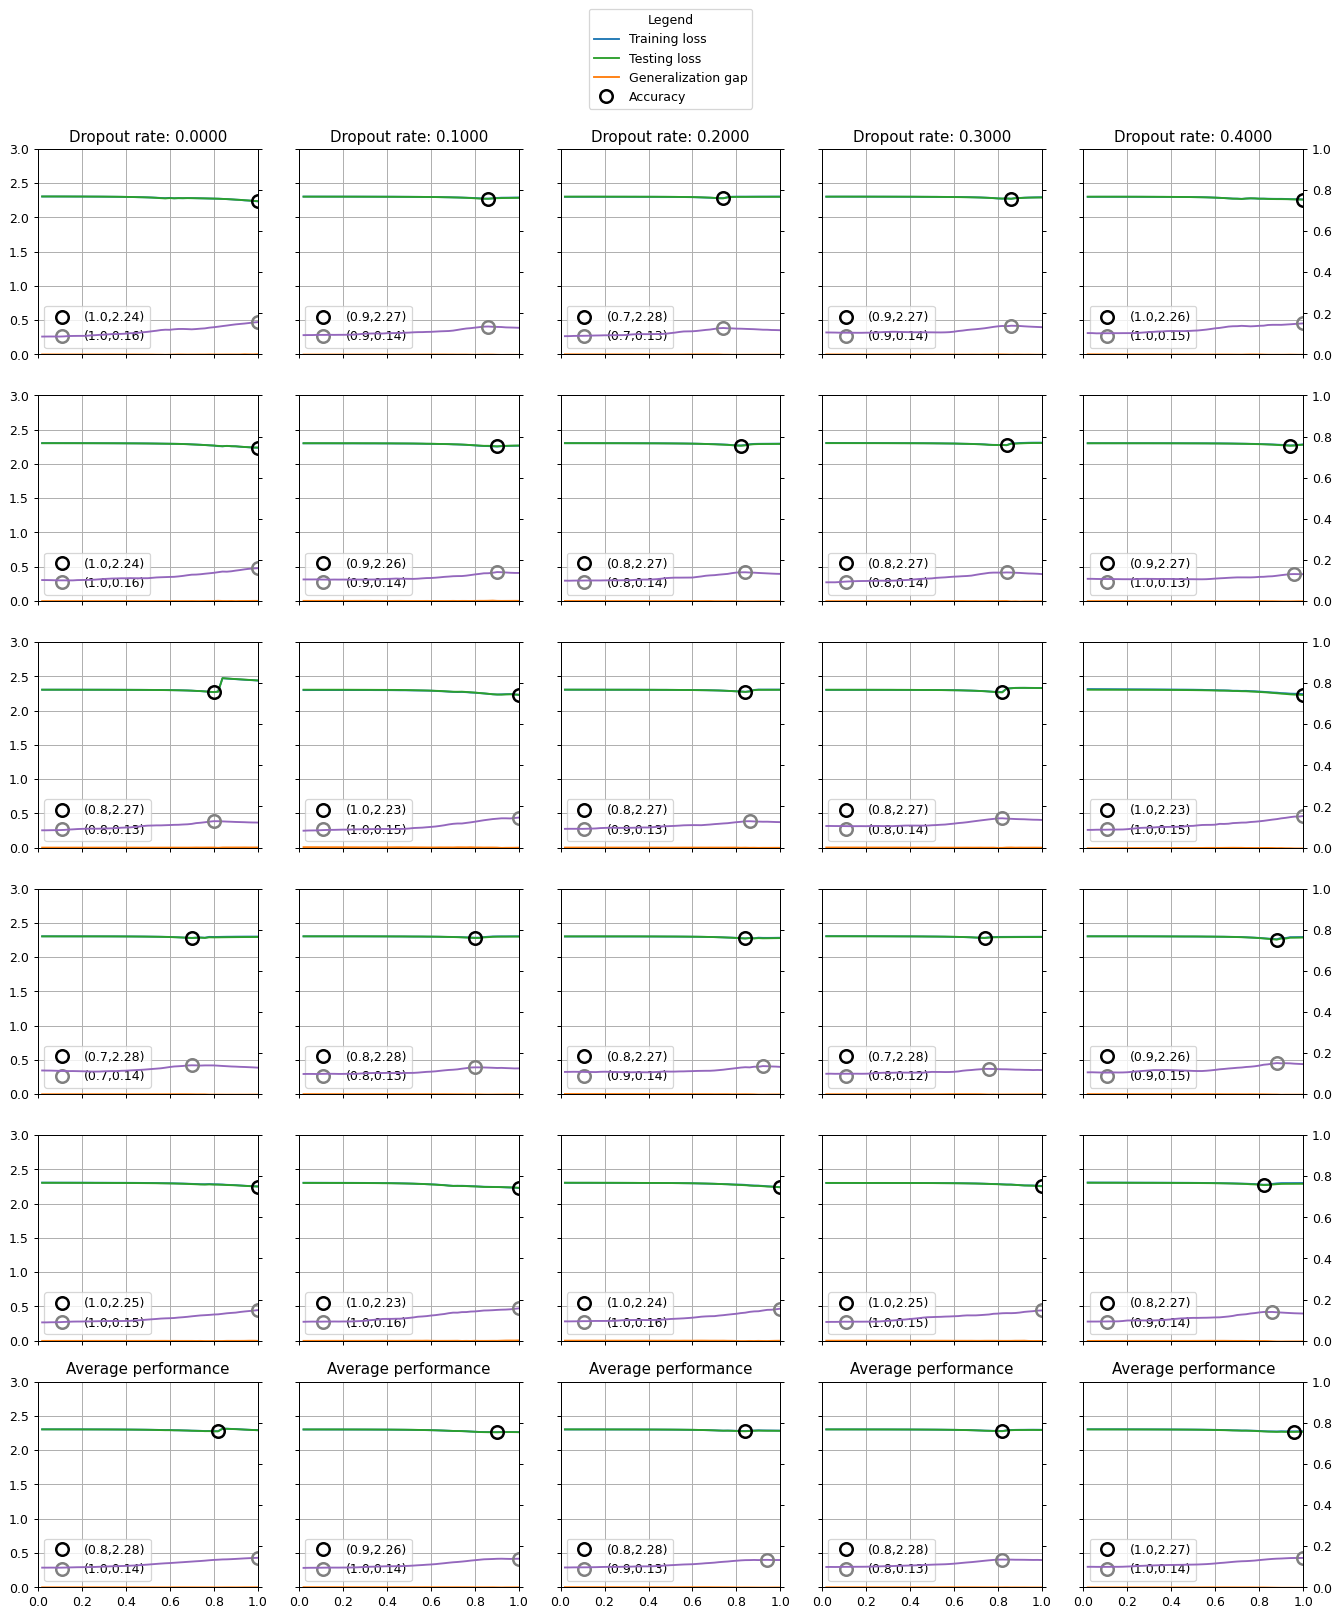

In [9]:
with open('results.pickle','rb+') as f:
    results = pickle.load(f)

# Creating a 6x5 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,18))

# Plotting data in each subplot
for col, dr in enumerate(results['dropout_rate']):
    performance_mean = rec_mean(results['dropout_rate'][dr])
    for row, data in enumerate(results['dropout_rate'][dr][:5]+[performance_mean]):
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==4)
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)
        if row == 0: axes[row,col].set_title(f'Dropout rate: {dr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1), fontsize='medium')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [52]:
# Swapping the training and testing sets
train_set, test_set = test_set, train_set

def new_head(old_model):
    
    new_model = deepcopy(old_model)
    
    for param in new_model.conv_layers.parameters():
        param.requires_grad = False
    
    new_model.full_layers.apply(
        lambda l: l.reset_parameters()
            if hasattr(l,'reset_parameters')
            else None)
    
    return new_model

no_dropout_model      = new_head(dropout_models[0.0])
best_performing_model = new_head(dropout_models[0.1])

loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(no_dropout_model.parameters(), lr=0.08, momentum=0.9)
scheduler = None
no_dropout_transfer_metrics = train_and_test(no_dropout_model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 12, device)

loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(best_performing_model.parameters(), lr=0.08, momentum=0.9)
scheduler = None
best_performing_transfer_metrics = train_and_test(best_performing_model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 0, device)

### Experiment 3 (19 MARKS) <ignore>

*Write up results for Experiment 3 here*

In [ ]:
#############################
### Code for Experiment 3 ###
#############################

In [ ]:
# When you get here you should have metrics for the model that doesn't use dropout
# Plot its gradients using plot_gradient_stats()

# When you get here you should have metrics for the best-performing model that uses dropout (before the transfer learning experiment)
# Plot its gradients using plot_gradient_stats()


# Redefine the train-test split

# Create a new model that does not use dropout but which uses batch normalization
# Call train_and_test() on it and get its metrics
# Plot its gradients using plot_gradient_stats()

# Plot the learning curves for the batch normalized model

In [109]:
my_nn = NeuralNetwork(batch_norm=True).to(device)

loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_nn.parameters(), lr=0.08, momentum=0.9)
scheduler = None
my_nn_metrics = train_and_test(my_nn, train_set, test_set, 50, loss_fn, optimizer, scheduler, 12, device)

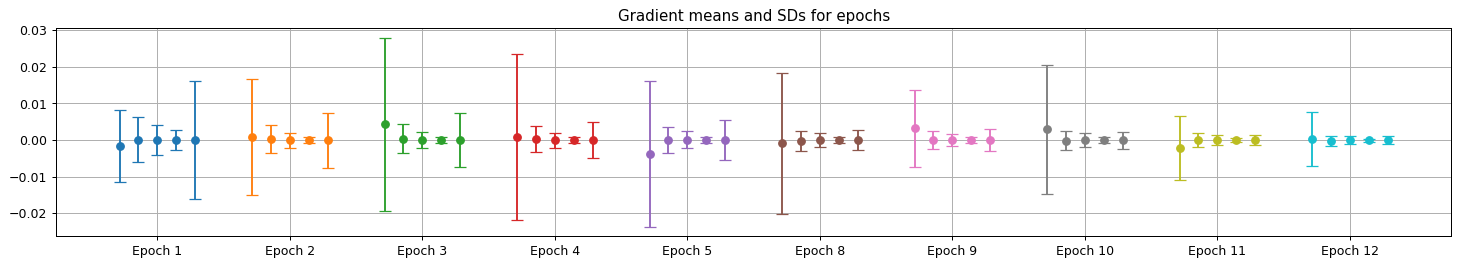

In [119]:
plot_gradient_stats(my_nn_metrics)

# Conclusions and Discussion (instructions) - 25 MARKS <ignore>
In this section, you are expected to:
* briefly summarise and describe the conclusions from your experiments (8 MARKS).
* discuss whether or not your results are expected, providing scientific reasons (8 MARKS).
* discuss two or more alternative/additional methods that may enhance your model, with scientific reasons (4 MARKS). 
* Reference two or more relevant academic publications that support your discussion. (4 MARKS)

*Write your Conclusions/Discussion here*

# References (instructions) <ignore>
Use the cell below to add your references. A good format to use for references is like this:

[AB Name], [CD Name], [EF Name] ([year]), [Article title], [Journal/Conference Name] [volume], [page numbers] or [article number] or [doi]

Some examples:

JEM Bennett, A Phillipides, T Nowotny (2021), Learning with reinforcement prediction errors in a model of the Drosophila mushroom body, Nat. Comms 12:2569, doi: 10.1038/s41467-021-22592-4

SO Kaba, AK Mondal, Y Zhang, Y Bengio, S Ravanbakhsh (2023), Proc. 40th Int. Conf. Machine Learning, 15546-15566

*List your references here*